In [60]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 

import mlflow
import mlflow.sklearn
import joblib
import warnings


import pandas as pd
from pandas.api.types import is_object_dtype

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [61]:
df = pd.read_csv('./data/Credit.csv')
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


In [62]:
df.shape

(1000, 21)

In [63]:
label_encoders_dict = {}

# Transformando os dados categóricos em numéricos
for column in df.columns:
    if is_object_dtype(df[column]):
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders_dict[column] = le

In [64]:
X = df.drop(['class'], axis=1)
Y = df['class']

In [65]:
# Verificar se os dados estão balanceados
Y.value_counts()

class
1    700
0    300
Name: count, dtype: int64

In [66]:
# Vamos criar dados sintéticos para balancear os dados
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X, Y)
Y_smote.value_counts()

class
1    700
0    700
Name: count, dtype: int64

In [67]:
x_train, x_test, y_train, y_test = train_test_split(X_smote.values, Y_smote.values, test_size=0.3 , random_state=123)

modelo: f9d93b4536f249b8b45239e3c9819190
artifacts: mlflow-artifacts:/707715376824476266/f9d93b4536f249b8b45239e3c9819190/artifacts
params: {}
metrics: {}


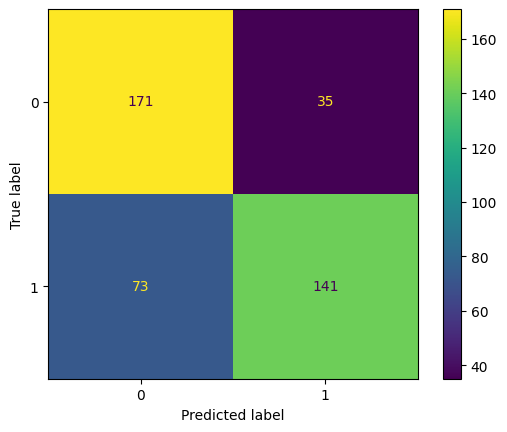

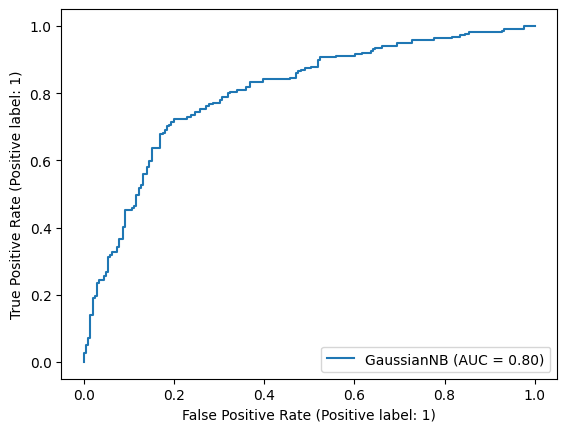

In [68]:
mlflow.set_experiment('NB_Credit_Experiment')

with mlflow.start_run(run_name='NB_Credit'):
    naive_bayes = GaussianNB()
    naive_bayes.fit(x_train, y_train)

    # Acurácia = (TP + TN) / (TP + TN + FP + FN)
    # TP = True Positive
    # TN = True Negative
    # FP = False Positive
    # FN = False Negative

    predict = naive_bayes.predict(x_test)
    
    # registrar metricas
    mlflow.log_metric('score', naive_bayes.score(x_test, y_test))
    mlflow.log_metric('accuracy', accuracy_score(y_test, predict))
    mlflow.log_metric('precision', precision_score(y_test, predict))
    mlflow.log_metric('recall', recall_score(y_test, predict))
    mlflow.log_metric('f1', f1_score(y_test, predict))
    mlflow.log_metric('roc_auc', roc_auc_score(y_test, predict))
    mlflow.log_metric('log_loss', log_loss(y_test, predict))

    id_model = mlflow.active_run().info.run_id

    # gráfico da matriz de confusão
    # explicação: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
    
    confusion = confusion_matrix(y_test, predict, labels=naive_bayes.classes_)
    ConfusionMatrixDisplay.from_estimator(naive_bayes, x_test, y_test).figure_.savefig(f'./images/confusion_matrix_{id_model}.png')
    mlflow.log_artifact(f'./images/confusion_matrix_{id_model}.png')

    # gráfico da curva ROC
    RocCurveDisplay.from_estimator(naive_bayes, x_test, y_test).figure_.savefig(f'./images/roc_curve_{id_model}.png')
    mlflow.log_artifact(f'./images/roc_curve_{id_model}.png')

    # informações sobre o modelo
    print(f'modelo: {mlflow.active_run().info.run_id}')
    print(f'artifacts: {mlflow.active_run().info.artifact_uri}')
    print(f'params: {mlflow.active_run().data.params}')
    print(f'metrics: {mlflow.active_run().data.metrics}')

    # salvar label encoders
    joblib.dump(label_encoders_dict, f'./models/label_encoders_{id_model}.joblib')
    mlflow.log_artifact(f'./models/label_encoders_{id_model}.joblib', artifact_path='models')

    # salvar dataset
    dataset = mlflow.data.from_pandas(df, './data/Credit.csv')
    mlflow.log_input(dataset)

    # salvar modelo
    mlflow.sklearn.log_model(naive_bayes, f'nb_{id_model}')

mlflow.end_run()

In [69]:
# carregar label encoders

label_encoders_dict = joblib.load(f'./models/label_encoders_{id_model}.joblib')

In [70]:
# Previsões
# passando X.values para prever todas as linhas
df['previsoes'] = naive_bayes.predict(X.values)

In [71]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,previsoes
0,2,6,1,7,1169,0,3,4,3,2,4,2,67,1,1,2,3,1,1,1,1,1
1,1,48,3,7,5951,3,0,2,0,2,2,2,22,1,1,1,3,1,0,1,0,0
2,0,12,1,4,2096,3,1,2,3,2,3,2,49,1,1,1,2,2,0,1,1,1
3,2,42,3,5,7882,3,1,2,3,1,4,0,45,1,0,1,3,2,0,1,1,0
4,2,24,2,1,4870,3,0,3,3,2,4,1,53,1,0,2,3,2,0,1,0,1


In [72]:
df_decoded = df.copy()

for column in df_decoded.columns:
    if label_encoders_dict.get(column):
        df_decoded[column] = label_encoders_dict[column].inverse_transform(df_decoded[column])

df_decoded['previsoes'] = label_encoders_dict['class'].inverse_transform(df_decoded['previsoes'])

df_decoded.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,previsoes
0,<0,6,'critical/other existing credit',radio/tv,1169,'no known savings',>=7,4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good,good
1,0<=X<200,48,'existing paid',radio/tv,5951,<100,1<=X<4,2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad,bad
2,'no checking',12,'critical/other existing credit',education,2096,<100,4<=X<7,2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good,good
3,<0,42,'existing paid',furniture/equipment,7882,<100,4<=X<7,2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good,bad
4,<0,24,'delayed previously','new car',4870,<100,1<=X<4,3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad,good
